<h1>NYC Rent Affordability Investigation:<br>Change Point Detection & Forecasting</h1>

This is an investigation of rent affordability in NYC using neighborhood-level and borough-level from 2012-2022. 

I am using median rent data from the [Streeteasy Dashboard](https://streeteasy.com/blog/data-dashboard/), and median income data from the [U.S. Census American Community Survey](https://www.census.gov/programs-surveys/acs/data.html).

Here, I'll be doing some Exploratory Data Analysis, looking at the relationship between median rent and household income over the last decade.

# Importing packages and modules

In [1]:
# data management + manipulation
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# env vars + Big Query access
import os
import json
from google.cloud import bigquery
from google.oauth2 import service_account
# changepoint detection module
import ruptures as rpt
# removing excess logs
import warnings
warnings.filterwarnings('ignore')

# Import rent and income data from Big Query

In [2]:
# configure Big Query connection
PROJECT_ID = "rent-affordability"
DATASET_ID = "nyc_analysis"
service_account_info = json.loads(os.environ["GOOGLE_CREDENTIALS_JSON"])
credentials = service_account.Credentials.from_service_account_info(service_account_info)
client = bigquery.Client(project=PROJECT_ID, credentials=credentials)

In [8]:
# importing monthly median rent data at the borough level
rent_query = """
SELECT 
    b.name as borough,
    mr.year,
    mr.month,
    AVG(mr.all_apartments) as avg_rent_all,
    AVG(mr.one_bedroom) as avg_rent_1bed,
    AVG(mr.three_plus_bedroom) as avg_rent_3bed
FROM nyc_analysis.fact_median_rent mr
JOIN nyc_analysis.ref_neighborhoods n ON mr.neighborhood_id = n.neighborhood_id
JOIN nyc_analysis.ref_boroughs b ON mr.borough_id = b.borough_id
WHERE mr.all_apartments IS NOT NULL
GROUP BY b.name, mr.year, mr.month
ORDER BY b.name, mr.year, mr.month
"""

rent_df = client.query(rent_query).to_dataframe()
rent_df['date'] = pd.to_datetime(rent_df[['year', 'month']].assign(day=1))
rent_df = rent_df.sort_values('date')
numeric_cols = ['avg_rent_all','avg_rent_1bed','avg_rent_3bed']
for col in numeric_cols:
    rent_df[col] = rent_df[col].astype('float32')
print(f"Loaded {len(rent_df)} monthly rent records")
rent_df

Loaded 756 monthly rent records


,borough,year,month,avg_rent_all,avg_rent_1bed,avg_rent_3bed,date
0,Bronx,2010,01,1361.333374,500.000000,833.333313,2010-01-01
189,Brooklyn,2010,01,2006.370361,1125.296265,929.037048,2010-01-01
567,Queens,2010,01,1571.916626,741.166687,591.666687,2010-01-01
378,Manhattan,2010,01,3088.500000,2454.571533,4880.643066,2010-01-01
568,Queens,2010,02,1539.153809,603.846130,419.230774,2010-02-01
...,...,...,...,...,...,...,...
187,Bronx,2025,08,2659.769287,1267.153809,965.384644,2025-08-01
377,Brooklyn,2025,09,3593.699951,2898.300049,4548.100098,2025-09-01
188,Bronx,2025,09,2601.266602,1152.666626,881.666687,2025-09-01
566,Manhattan,2025,09,4911.096680,4420.645020,8034.806641,2025-09-01


In [51]:
# importing year-over-year percentage change rent data at the borough level
yoy_rent_query = """
SELECT 
    borough_name as borough,
    year,
    AVG(yoy_change_pct_all) as yoy_rent_change_pct_all,
    AVG(yoy_change_pct_1bdr) as yoy_rent_change_pct_1bed,
    AVG(yoy_change_pct_3bdr) as yoy_rent_change_pct_3bed
FROM nyc_analysis.agg_yoy_rent_change
WHERE yoy_change_pct_all IS NOT NULL
GROUP BY borough_name, year
ORDER BY borough_name, year
"""

yoy_rent_df = client.query(yoy_rent_query).to_dataframe()
print(f"Loaded {len(yoy_rent_df)} YoY rent records")
numeric_cols = ['yoy_rent_change_pct_all','yoy_rent_change_pct_1bed','yoy_rent_change_pct_3bed']
for col in numeric_cols:
    yoy_rent_df[col] = yoy_rent_df[col].astype('float32')
yoy_rent_df

Loaded 60 YoY rent records


,borough,year,yoy_rent_change_pct_all,yoy_rent_change_pct_1bed,yoy_rent_change_pct_3bed
0,Bronx,2011,-11.445000,20.959999,41.400002
1,Bronx,2012,12.114000,120.400002,7.650000
2,Bronx,2013,3.497778,-57.132500,-59.000000
3,Bronx,2014,5.374546,240.779999,20.389999
4,Bronx,2015,6.770000,-5.230769,-10.070000
5,Bronx,2016,9.224167,4.312632,-18.612000
6,Bronx,2017,10.806400,27.962778,-26.135000
7,Bronx,2018,6.642667,-26.999474,61.543335
8,Bronx,2019,2.661786,31.848125,17.298462
9,Bronx,2020,1.048929,-31.472857,-83.362938


In [10]:
# importing monthly median household income data at the borough level
income_query = """
SELECT 
    b.name as borough,
    mi.year,
    AVG(mi.income_all_hhs) as avg_income_all,
    AVG(mi.income_singles) as avg_income_singles,
    AVG(mi.income_married_kids) as avg_income_married_kids,
    AVG(mi.income_other_kids) as avg_income_other_kids
FROM nyc_analysis.fact_median_income mi
JOIN nyc_analysis.ref_boroughs b ON mi.borough_id = b.borough_id
WHERE mi.income_all_hhs IS NOT NULL
GROUP BY b.name, mi.year
ORDER BY b.name, mi.year
"""

income_df = client.query(income_query).to_dataframe()
income_df = income_df.sort_values('year')
numeric_cols = ['avg_income_all','avg_income_singles','avg_income_married_kids','avg_income_other_kids']
for col in numeric_cols:
    income_df[col] = income_df[col].astype('float32')
print(f"Loaded {len(income_df)} monthly income records")
income_df

Loaded 50 monthly income records


,borough,year,avg_income_all,avg_income_singles,avg_income_married_kids,avg_income_other_kids
0,Bronx,2012,34288.300781,23651.800781,6729.399902,55.299999
10,Brooklyn,2012,46926.175781,34058.175781,11759.352539,195.705887
30,Queens,2012,55517.000000,37697.429688,15440.071289,163.428574
20,Manhattan,2012,65808.000000,54534.500000,1849.000000,5.800000
40,Staten Island,2012,69912.335938,36389.000000,8860.333008,11.000000
21,Manhattan,2013,72803.898438,59493.601562,1879.400024,26.100000
11,Brooklyn,2013,49611.941406,36755.468750,10417.293945,156.882355
31,Queens,2013,57795.070312,38442.785156,15912.142578,84.857140
41,Staten Island,2013,71515.664062,38107.667969,8640.000000,23.666666
1,Bronx,2013,36480.300781,23462.699219,6867.100098,101.400002


In [68]:
# importing year-over-year percentage change income data at the borough level
yoy_income_query = """
SELECT 
    borough_name as borough,
    year,
    AVG(yoy_change_pct_all_hhs) as yoy_income_change_pct_all_hhs,
    AVG(yoy_change_pct_singles) as yoy_income_change_pct_singles,
    AVG(yoy_change_pct_married_kids) as yoy_income_change_pct_married_kids,
    AVG(yoy_change_pct_other_kids) as yoy_income_change_pct_other_kids
FROM nyc_analysis.agg_yoy_income_change
WHERE yoy_change_pct_singles IS NOT NULL
GROUP BY borough_name, year
ORDER BY borough_name, year
"""

yoy_income_df = client.query(yoy_income_query).to_dataframe()
numeric_cols = ['yoy_income_change_pct_all_hhs','yoy_income_change_pct_singles','yoy_income_change_pct_married_kids','yoy_income_change_pct_other_kids']
for col in numeric_cols:
    yoy_income_df[col] = yoy_income_df[col].astype('float32')
print(f"Loaded {len(yoy_income_df)} YoY income records")
yoy_income_df

Loaded 47 YoY income records


,borough,year,yoy_income_change_pct_all_hhs,yoy_income_change_pct_singles,yoy_income_change_pct_married_kids,yoy_income_change_pct_other_kids
0,Bronx,2013,5.565200,-1.431200,-2.884615,-51.101665
1,Bronx,2014,2.575200,9.272000,2.940769,141.293076
2,Bronx,2015,0.945200,-2.399200,-18.376249,24.535625
3,Bronx,2016,9.070000,7.122000,-1.346154,42.796925
4,Bronx,2017,1.860800,-8.378800,-57.756668,-73.240837
5,Bronx,2018,0.866000,10.240000,-51.424999,-59.209999
6,Bronx,2019,7.990000,13.676400,-100.000000,-100.000000
7,Bronx,2021,2.533600,1.559600,NaN,NaN
8,Bronx,2022,6.332609,12.889131,-100.000000,-100.000000
9,Brooklyn,2012,-7.430000,-38.529999,NaN,NaN


# Rent + Income Timeseries, and YoY Change Trends

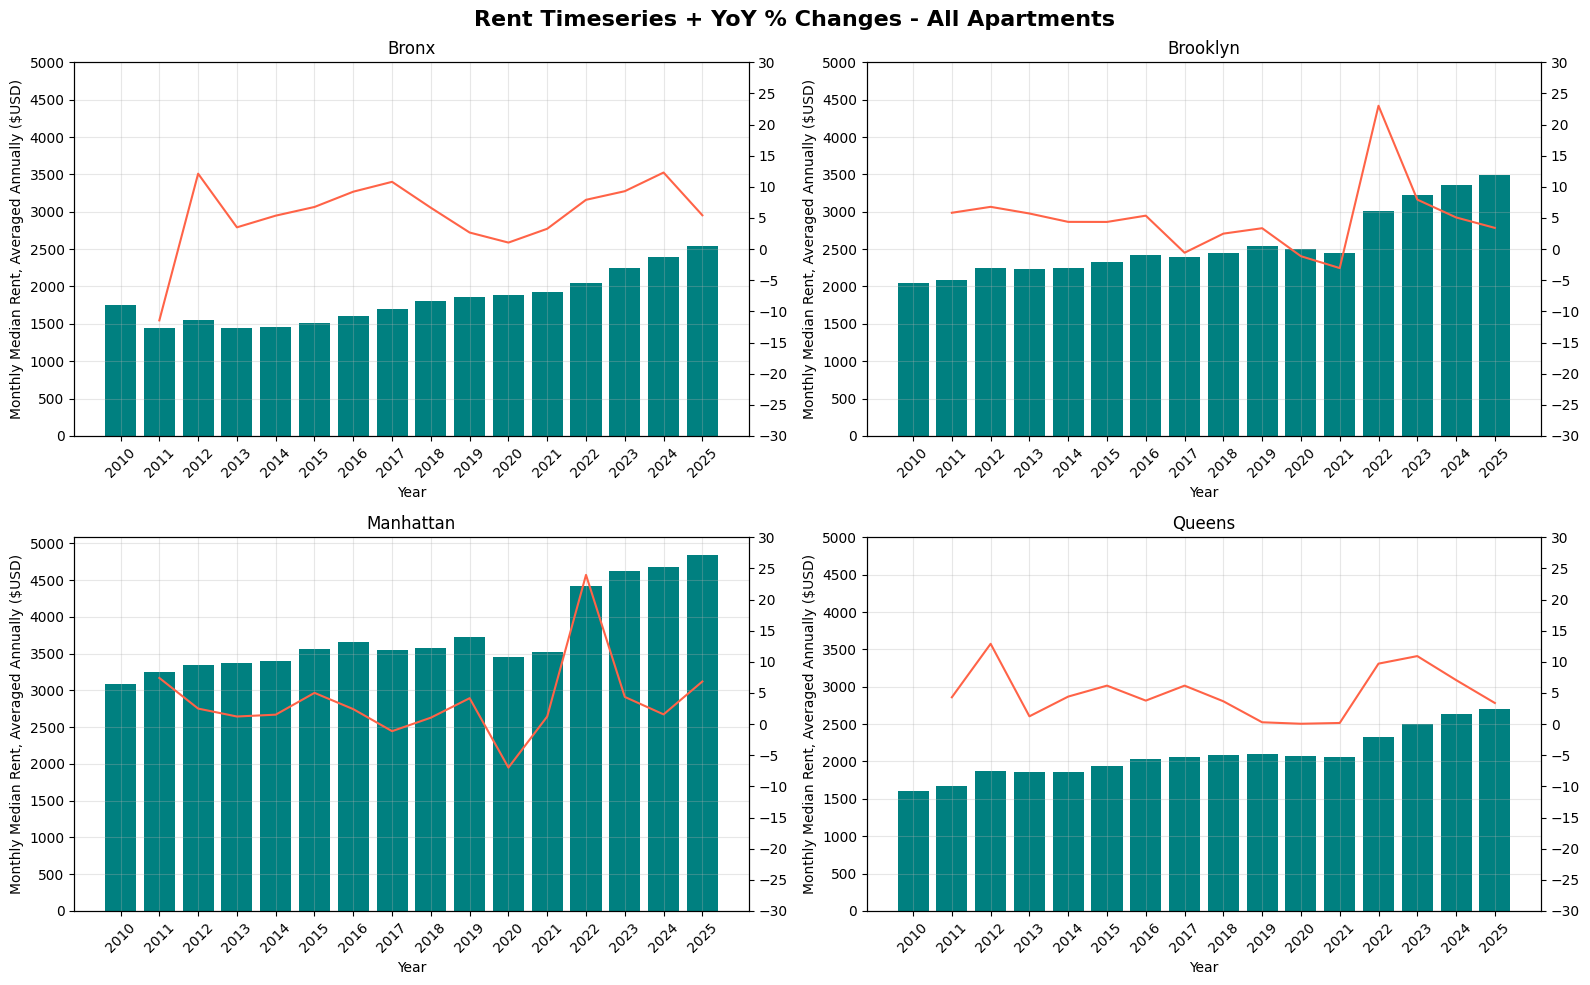

In [ ]:
boroughs = ['Bronx','Brooklyn','Manhattan','Queens']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Rent Timeseries + YoY % Changes - All Apartments', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(boroughs):
    ax = axes[idx]
    ax.set_title(f'{borough}')
    rent_data = rent_df[rent_df['borough'] == borough].groupby('year')['avg_rent_all'].mean().copy()
    yoy_data = pd.Series(yoy_rent_df[yoy_rent_df['borough'] == borough]['yoy_rent_change_pct_all'].values, 
                            index=yoy_rent_df[yoy_rent_df['borough'] == borough]['year'])
    
    ax.bar(rent_data.index.to_numpy(), rent_data, color='teal')
    ax2 = ax.twinx()
    ax2.plot(yoy_data.index.to_numpy(), yoy_data, ms=3, color='tomato')

    ax.set_xlabel('Year')
    ax.set_xticks(range(2010,2026))
    ax.set_ylabel('Monthly Median Rent, Averaged Annually ($USD)')
    ax.set_yticks(range(0,5500,500))
    ax2.set_yticks(range(-30,35,5))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()  

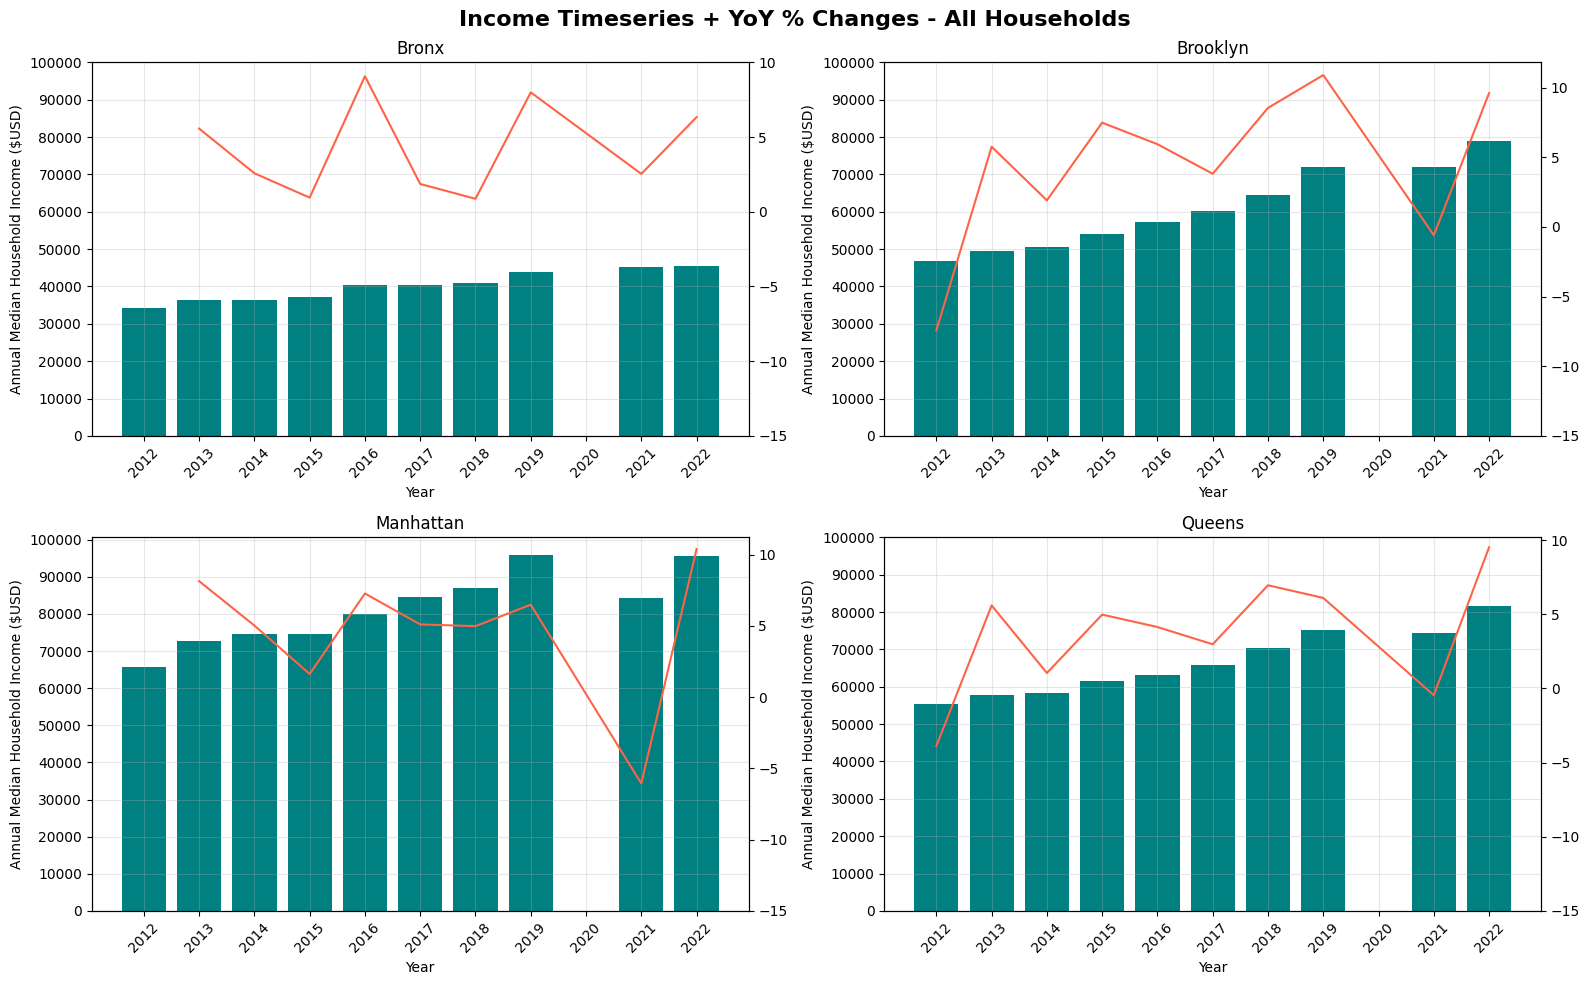

In [ ]:
boroughs = ['Bronx','Brooklyn','Manhattan','Queens']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Income Timeseries + YoY % Changes - All Households', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(boroughs):
    ax = axes[idx]
    ax.set_title(f'{borough}')
    income_data = income_df[income_df['borough'] == borough].groupby('year')['avg_income_all'].mean()
    yoy_data = pd.Series(yoy_income_df[yoy_income_df['borough'] == borough]['yoy_income_change_pct_all_hhs'].values, 
                            index=yoy_income_df[yoy_income_df['borough'] == borough]['year'])
    
    ax.bar(income_data.index.to_numpy(), income_data, color='teal')
    ax2 = ax.twinx()
    ax2.plot(yoy_data.index.to_numpy(), yoy_data, ms=3, color='tomato')

    ax.set_xlabel('Year')
    ax.set_xticks(range(2012,2023))
    ax.set_ylabel('Annual Median Household Income ($USD)')
    ax.set_yticks(range(0,110000,10000))
    ax2.set_yticks(range(-15,15,5))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()  

# YoY Change in Rent & Income Trends, comparitively

## All Households vs. All Apartments

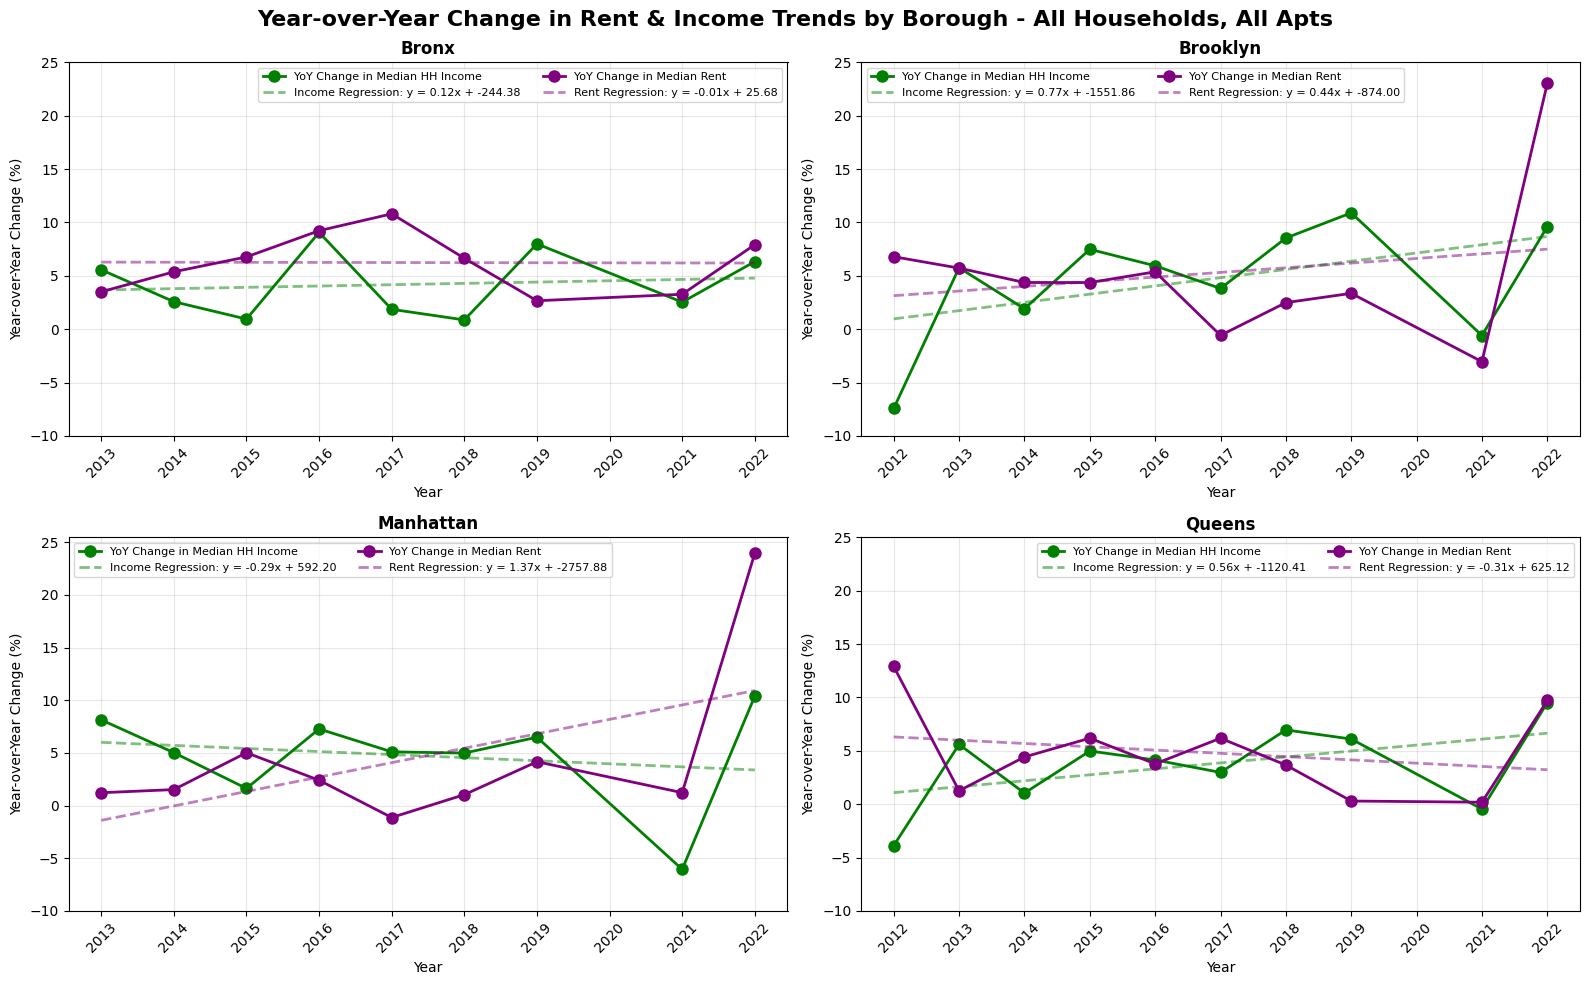

In [69]:
# plotting YoY Rent and Income changes at the borough-level
income_color = 'green'
rent_color = 'purple'

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Year-over-Year Change in Rent & Income Trends by Borough - All Households, All Apts', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(yoy_rent_df['borough'].unique()):
    # getting income data
    income_data = yoy_income_df[yoy_income_df['borough'] == borough].copy()
    income_data = income_data.sort_values('year')
    # getting rent data
    rent_data = yoy_rent_df[yoy_rent_df['borough'] == borough].copy()
    rent_data = rent_data.sort_values('year')
    rent_data['yoy_rent_change_pct_all'] = rent_data['yoy_rent_change_pct_all'].astype(np.float32)
    # subsetting to match available income years
    rent_data = rent_data[np.isin(rent_data['year'], income_data['year'])]

    ax = axes[idx]

    # plotting income data
    ax.plot(income_data['year'], income_data['yoy_income_change_pct_all_hhs'], marker='o', ms=8, 
            linewidth=2, label='YoY Change in Median HH Income', color=income_color)
    # calculate the polynomial values
    m, b = np.polyfit(income_data['year'], income_data['yoy_income_change_pct_all_hhs'], 1)
    # plot the linear regression line
    ax.plot(income_data['year'], (m*income_data['year'] + b), color=income_color, linestyle='--',
            linewidth=2, label=f'Income Regression: y = {m:.2f}x + {b:.2f}', alpha=0.5)
    
    # plotting rent data
    ax.plot(rent_data['year'], rent_data['yoy_rent_change_pct_all'], marker='o', 
            ms=8, linewidth=2, label='YoY Change in Median Rent', color=rent_color)
    # calculate the polynomial values
    m, b = np.polyfit(rent_data['year'], rent_data['yoy_rent_change_pct_all'], 1)
    # plot the linear regression line
    ax.plot(rent_data['year'], (m*rent_data['year'] + b), color=rent_color, linewidth=2, 
            label=f'Rent Regression: y = {m:.2f}x + {b:.2f}', linestyle='--', alpha=0.5)
    
    ax.set_title(f'{borough}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_xticks(range(income_data['year'].iloc[0],income_data['year'].iloc[-1]+1))
    ax.set_ylabel('Year-over-Year Change (%)')
    ax.set_yticks(range(-10,30,5))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Single-person HHs vs. 1Bdr Apartments

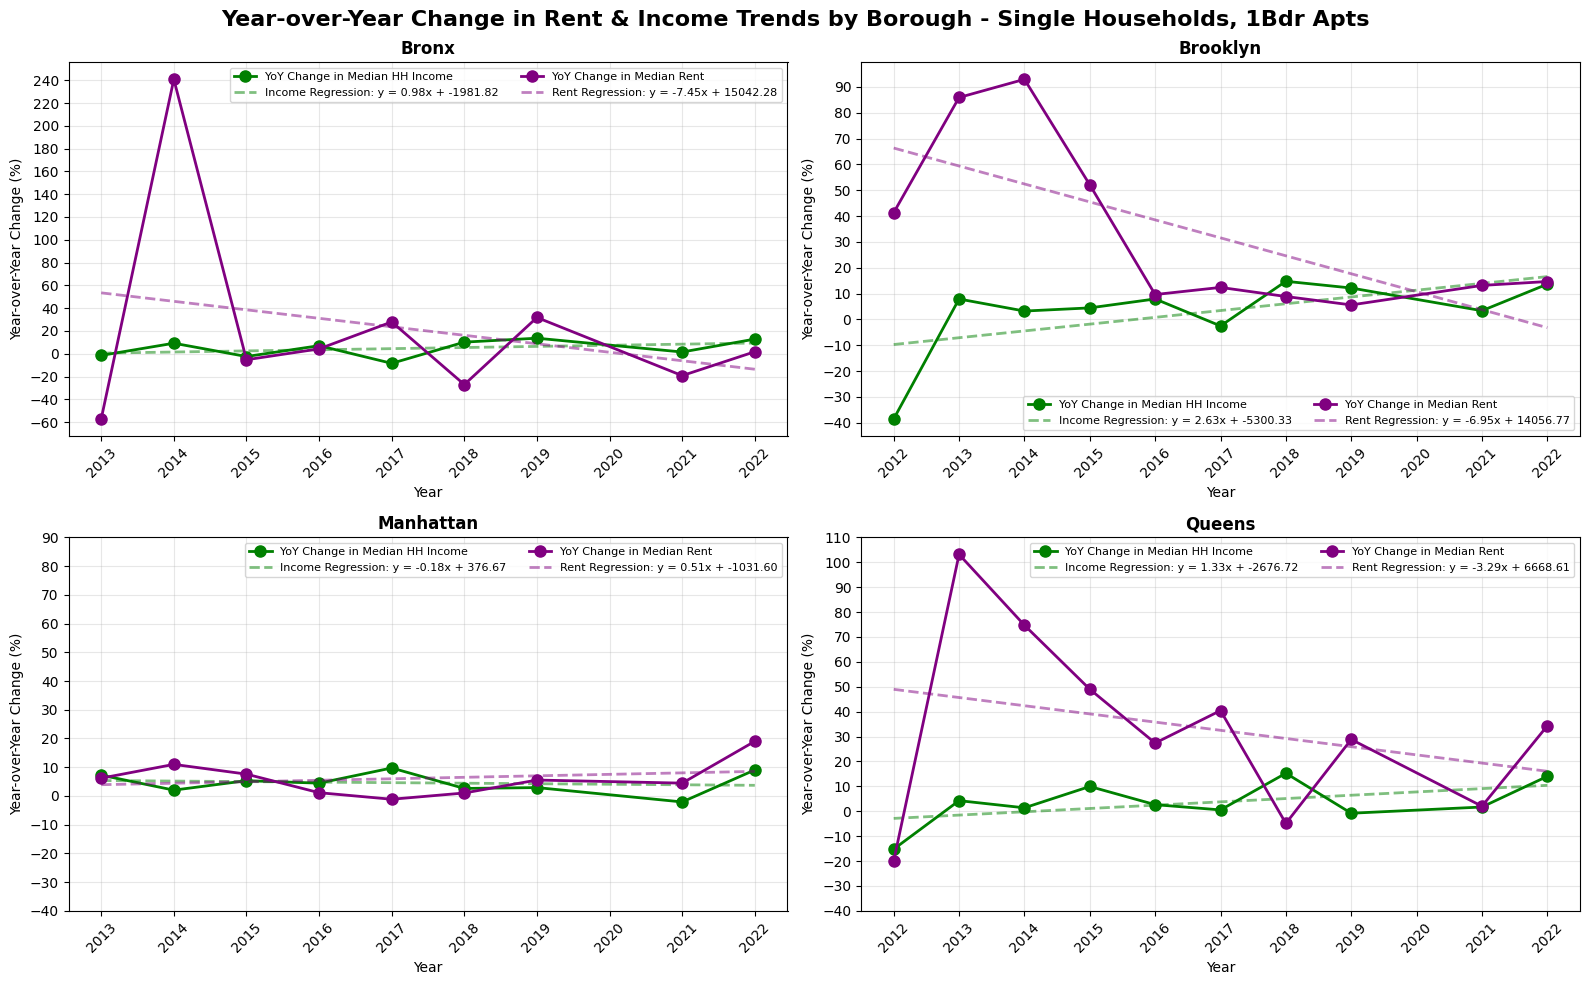

In [71]:
# plotting YoY Rent and Income changes at the borough-level
income_color = 'green'
rent_color = 'purple'

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Year-over-Year Change in Rent & Income Trends by Borough - Single Households, 1Bdr Apts', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(yoy_rent_df['borough'].unique()):
    # getting income data
    income_data = yoy_income_df[yoy_income_df['borough'] == borough].copy()
    income_data = income_data.sort_values('year')
    income_data['yoy_income_change_pct_singles'] = income_data['yoy_income_change_pct_singles'].astype(np.float32)
    # getting rent data
    rent_data = yoy_rent_df[yoy_rent_df['borough'] == borough].copy()
    rent_data = rent_data.sort_values('year')
    rent_data['yoy_rent_change_pct_1bed'] = rent_data['yoy_rent_change_pct_1bed'].astype(np.float32)
    # subsetting to match available income years
    rent_data = rent_data[np.isin(rent_data['year'], income_data['year'])]

    ax = axes[idx]

    # plotting income data
    ax.plot(income_data['year'], income_data['yoy_income_change_pct_singles'], marker='o', ms=8, 
            linewidth=2, label='YoY Change in Median HH Income', color=income_color)
    # calculate the polynomial values
    m, b = np.polyfit(income_data['year'], income_data['yoy_income_change_pct_singles'], 1)
    # plot the linear regression line
    ax.plot(income_data['year'], (m*income_data['year'] + b), color=income_color, linestyle='--',
            linewidth=2, label=f'Income Regression: y = {m:.2f}x + {b:.2f}', alpha=0.5)
    
    # plotting rent data
    ax.plot(rent_data['year'], rent_data['yoy_rent_change_pct_1bed'], marker='o', 
            ms=8, linewidth=2, label='YoY Change in Median Rent', color=rent_color)
    # calculate the polynomial values
    m, b = np.polyfit(rent_data['year'], rent_data['yoy_rent_change_pct_1bed'], 1)
    # plot the linear regression line
    ax.plot(rent_data['year'], (m*rent_data['year'] + b), color=rent_color, linewidth=2, 
            label=f'Rent Regression: y = {m:.2f}x + {b:.2f}', linestyle='--', alpha=0.5)
    
    ax.set_title(f'{borough}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_xticks(range(income_data['year'].iloc[0],income_data['year'].iloc[-1]+1))
    ax.set_ylabel('Year-over-Year Change (%)')
    if np.isin(idx, 0):
        ax.set_yticks(range(-60,260,20))
    elif np.isin(idx, 3):
        ax.set_yticks(range(-40,120,10))
    else:
        ax.set_yticks(range(-40,95,10))     
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Households w. Children vs. 3Bdr Apartments

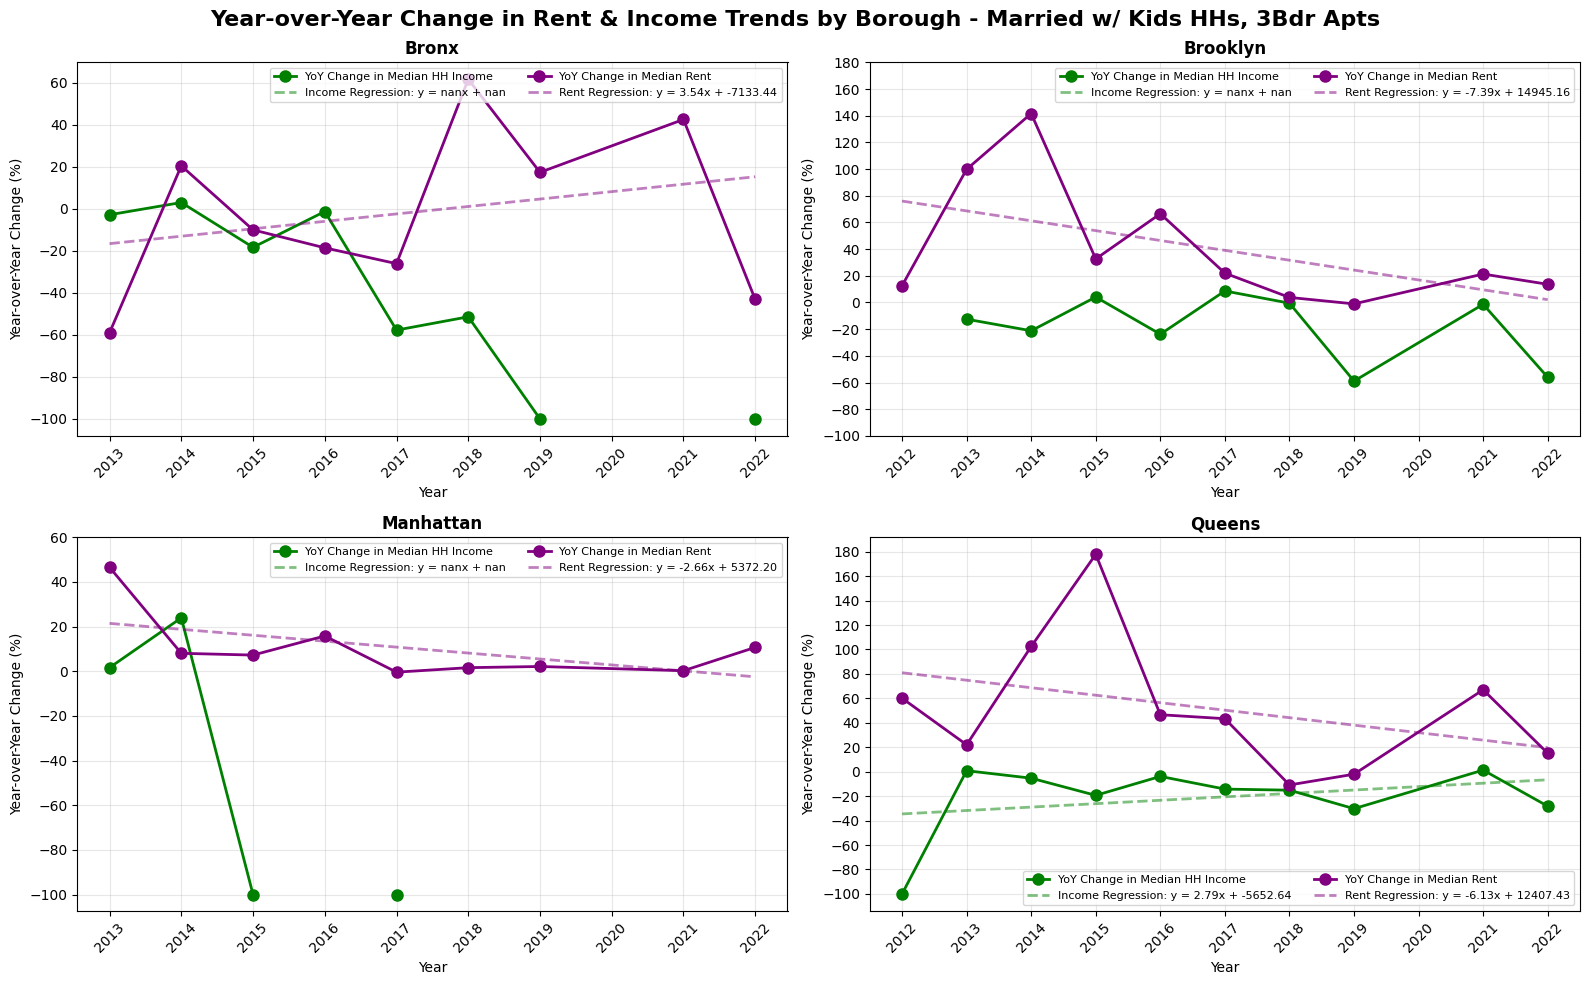

In [72]:
# plotting YoY Rent and Income changes at the borough-level
income_color = 'green'
rent_color = 'purple'

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Year-over-Year Change in Rent & Income Trends by Borough - Married w/ Kids HHs, 3Bdr Apts', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(yoy_rent_df['borough'].unique()):
    # getting income data
    income_data = yoy_income_df[yoy_income_df['borough'] == borough].copy()
    income_data = income_data.sort_values('year')
    income_data['yoy_income_change_pct_married_kids'] = income_data['yoy_income_change_pct_married_kids'].astype(np.float32)
    # getting rent data
    rent_data = yoy_rent_df[yoy_rent_df['borough'] == borough].copy()
    rent_data = rent_data.sort_values('year')
    rent_data['yoy_rent_change_pct_3bed'] = rent_data['yoy_rent_change_pct_3bed'].astype(np.float32)
    # subsetting to match available income years
    rent_data = rent_data[np.isin(rent_data['year'], income_data['year'])]

    ax = axes[idx]

    # plotting income data
    ax.plot(income_data['year'], income_data['yoy_income_change_pct_married_kids'], marker='o', ms=8, 
            linewidth=2, label='YoY Change in Median HH Income', color=income_color)
    # calculate the polynomial values
    m, b = np.polyfit(income_data['year'], income_data['yoy_income_change_pct_married_kids'], 1)
    # plot the linear regression line
    ax.plot(income_data['year'], (m*income_data['year'] + b), color=income_color, linestyle='--',
            linewidth=2, label=f'Income Regression: y = {m:.2f}x + {b:.2f}', alpha=0.5)
    
    # plotting rent data
    ax.plot(rent_data['year'], rent_data['yoy_rent_change_pct_3bed'], marker='o', 
            ms=8, linewidth=2, label='YoY Change in Median Rent', color=rent_color)
    # calculate the polynomial values
    m, b = np.polyfit(rent_data['year'], rent_data['yoy_rent_change_pct_3bed'], 1)
    # plot the linear regression line
    ax.plot(rent_data['year'], (m*rent_data['year'] + b), color=rent_color, linewidth=2, 
            label=f'Rent Regression: y = {m:.2f}x + {b:.2f}', linestyle='--', alpha=0.5)
    
    ax.set_title(f'{borough}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_xticks(range(income_data['year'].iloc[0],income_data['year'].iloc[-1]+1))
    ax.set_ylabel('Year-over-Year Change (%)')
    if np.isin(idx, [1,3]):
        ax.set_yticks(range(-100, 200, 20))
    else:
        ax.set_yticks(range(-100,75,20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

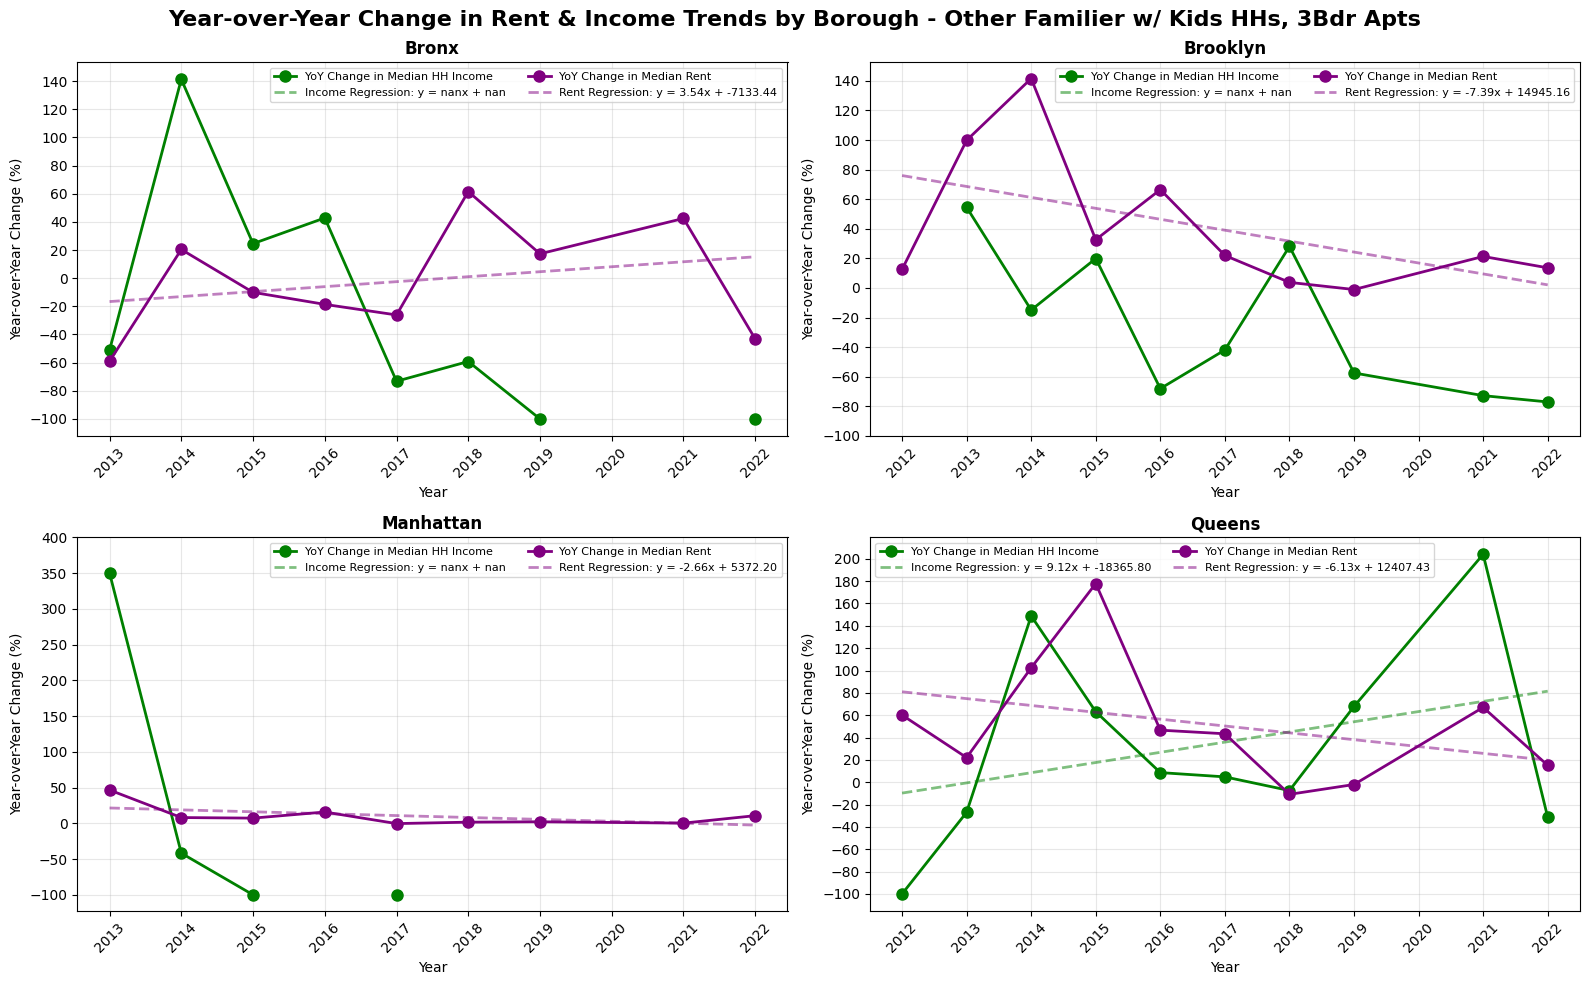

In [73]:
# plotting YoY Rent and Income changes at the borough-level
income_color = 'green'
rent_color = 'purple'

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Year-over-Year Change in Rent & Income Trends by Borough - Other Familier w/ Kids HHs, 3Bdr Apts', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(yoy_rent_df['borough'].unique()):
    # getting income data
    income_data = yoy_income_df[yoy_income_df['borough'] == borough].copy()
    income_data = income_data.sort_values('year')
    income_data['yoy_income_change_pct_other_kids'] = income_data['yoy_income_change_pct_other_kids'].astype(np.float32)
    # getting rent data
    rent_data = yoy_rent_df[yoy_rent_df['borough'] == borough].copy()
    rent_data = rent_data.sort_values('year')
    rent_data['yoy_rent_change_pct_3bed'] = rent_data['yoy_rent_change_pct_3bed'].astype(np.float32)
    # subsetting to match available income years
    rent_data = rent_data[np.isin(rent_data['year'], income_data['year'])]

    ax = axes[idx]

    # plotting income data
    ax.plot(income_data['year'], income_data['yoy_income_change_pct_other_kids'], marker='o', ms=8, 
            linewidth=2, label='YoY Change in Median HH Income', color=income_color)
    # calculate the polynomial values
    m, b = np.polyfit(income_data['year'], income_data['yoy_income_change_pct_other_kids'], 1)
    # plot the linear regression line
    ax.plot(income_data['year'], (m*income_data['year'] + b), color=income_color, linestyle='--',
            linewidth=2, label=f'Income Regression: y = {m:.2f}x + {b:.2f}', alpha=0.5)
    
    # plotting rent data
    ax.plot(rent_data['year'], rent_data['yoy_rent_change_pct_3bed'], marker='o', 
            ms=8, linewidth=2, label='YoY Change in Median Rent', color=rent_color)
    # calculate the polynomial values
    m, b = np.polyfit(rent_data['year'], rent_data['yoy_rent_change_pct_3bed'], 1)
    # plot the linear regression line
    ax.plot(rent_data['year'], (m*rent_data['year'] + b), color=rent_color, linewidth=2, 
            label=f'Rent Regression: y = {m:.2f}x + {b:.2f}', linestyle='--', alpha=0.5)
    
    ax.set_title(f'{borough}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_xticks(range(income_data['year'].iloc[0],income_data['year'].iloc[-1]+1))
    ax.set_ylabel('Year-over-Year Change (%)')
    if idx == 3:
        ax.set_yticks(range(-100,210, 20))
    elif idx == 2:
        ax.set_yticks(range(-100, 420, 50))
    else:
        ax.set_yticks(range(-100,160,20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Affordability Timeseries

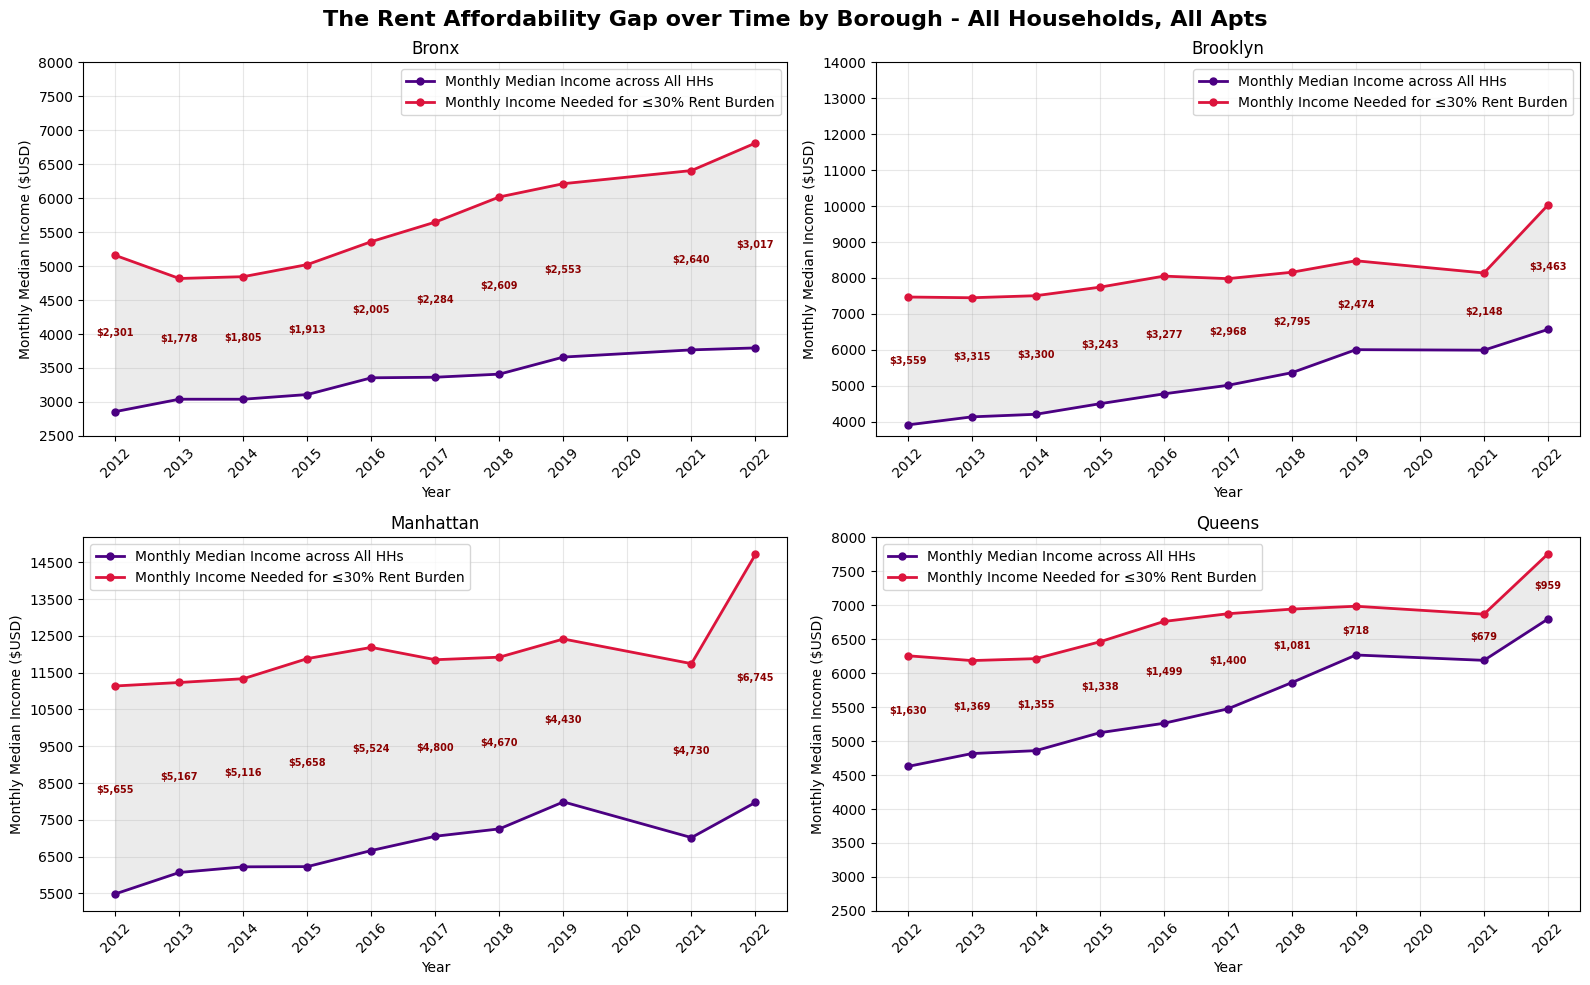

In [74]:
boroughs = ['Bronx','Brooklyn','Manhattan','Queens']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('The Rent Affordability Gap over Time by Borough - All Households, All Apts', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, borough in enumerate(boroughs):
    ax = axes[idx]
    ax.set_title(f'{borough}')
    income_data = pd.Series(income_df[income_df['borough'] == borough]['avg_income_all'].values, 
                            index=income_df[income_df['borough'] == borough]['year'])
    rent_data = rent_df[rent_df['borough'] == borough].groupby('year')['avg_rent_all'].mean().copy()
    rent_data = rent_data[np.isin(rent_data.index.to_numpy(), income_data.index.to_numpy())]
    
    monthly_income = income_data / 12
    income_needed = (rent_data * 100) / 30
    
    ax.plot(income_data.index.to_numpy(), monthly_income, marker='o', ms=5, color='indigo', 
            linewidth=2, label='Monthly Median Income across All HHs')
    ax.plot(rent_data.index.to_numpy(), income_needed, marker='o', ms=5, 
            linewidth=2, label='Monthly Income Needed for ≤30% Rent Burden', color='crimson')
    ax.fill_between(income_data.index.to_numpy(),
                    income_data/12,
                    ((rent_data*100)/30), color='silver', alpha=0.3)
    
    for year in income_data.index:
        inc_val = monthly_income[year]
        needed_val = income_needed[year]
        gap = needed_val - inc_val
        midpoint = (inc_val + needed_val) / 2
        ax.text(year, midpoint, f'${gap:,.0f}', ha='center', va='center', 
                fontsize=7, fontweight='bold', color='darkred')
    
    ax.set_xlabel('Year')
    ax.set_xticks(range(2012,2023))
    ax.set_ylabel('Monthly Median Income ($USD)')
    if np.isin(idx, [0,3]):
        ax.set_yticks(range(2500,8500,500))
    elif idx == 1:
        ax.set_yticks(range(4000, 15000, 1000))
    elif idx == 2:
        ax.set_yticks(range(5500, 15500, 1000))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()